# French Medical Named Entity Recognition (NER) Project

This notebook demonstrates the development and evaluation of medical Named Entity Recognition models for French clinical texts using various approaches, from traditional machine learning to transformer-based models.

## Project Structure

### 1. Setup & Data Preprocessing
- Loading QUAERO medical corpus
- Text cleaning and normalization
- Entity annotation processing

### 2. Feature Engineering
- TF-IDF vectorization
- Bag of Words (BoW)
- Word2Vec embeddings

### 3. Model Development
Implements and compares multiple NER approaches:
1. **Traditional ML Models**
   - Support Vector Machine (SVM)
   - Naive Bayes
   - Logistic Regression
   - Conditional Random Fields (CRF)

2. **Deep Learning Models**
   - CamemBERT (French BERT)
   - DrBERT (Medical domain BERT)

### 4. Evaluation & Visualization
- Entity type distribution analysis
- Model performance comparison
- Error analysis
- Confidence score visualization

## Key Features

- Medical entity types covered:
  - DISO (Disorders)
  - PROC (Procedures)
  - ANAT (Anatomical structures)
  - CHEM (Chemicals & Drugs)
  - PHYS (Physiology)

- Performance metrics:
  - Precision
  - Recall
  - F1-score
  - Entity-level accuracy

## Model Results

The notebook compares different approaches for French medical NER:
1. Traditional ML baseline (SVM, CRF)
2. Fine-tuned CamemBERT
3. Fine-tuned DrBERT (medical domain)

The final model (DrBERT) is deployed in a Streamlit application for real-time medical entity extraction.

## Requirements

- Python 3.8+
- transformers
- scikit-learn
- spaCy
- pytorch
- pandas
- nltk

In [ ]:
# Install required packages
!pip install pandas  scikit-learn transformers torch sklearn-crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
!pip install spacy
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 97.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 101.6 MB/s eta 0:00:00
✔ Download and installation successful
You ca

## 1. Setup & Data Loading





First, we need to mount Google Drive to access the *dataset*.

In [ ]:
from google.colab import drive
import os
import logging
from pathlib import Path
import pandas as pd

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class QuaeroProcessor:
    def __init__(self):
        self.drive_path = '/content/drive/MyDrive/data/corpus'

    def load_corpus(self):
        """Load corpus from single folder on Google Drive"""
        # Mount Google Drive
        drive.mount('/content/drive')
        logger.info("Google Drive mounted successfully")

        # Initialize data storage
        corpus_data = []

        # Process all .txt files in the corpus directory
        for txt_file in Path(self.drive_path).glob('*.txt'):
            ann_file = txt_file.with_suffix('.ann')

            if not ann_file.exists():
                logger.warning(f"Missing annotation file for {txt_file}")
                continue

            # Read text content
            with open(txt_file, 'r', encoding='utf-8') as f:
                text = f.read().strip()

            # Read annotations
            annotations = []
            with open(ann_file, 'r', encoding='utf-8') as f:
                for line in f:
                    if line.startswith('T'):
                        parts = line.strip().split('\t')
                        if len(parts) >= 3:
                            id_, type_span, text_span = parts
                            type_ = type_span.split()[0]
                            annotations.append({
                                'id': id_,
                                'type': type_,
                                'text': text_span
                            })

            corpus_data.append({
                'filename': txt_file.stem,
                'text': text,
                'annotations': annotations
            })

        # Convert to DataFrame
        df = pd.DataFrame(corpus_data)
        logger.info("\nCorpus Statistics:")
        logger.info(f"Total documents: {len(df)}")

        return df

# Run the processor
if __name__ == "__main__":
    processor = QuaeroProcessor()
    df = processor.load_corpus()

    # Display sample of the data
    print("\nSample of loaded data:")
    print(df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Sample of loaded data:
   filename                                               text  \
0  13317194  L' action de la testostérone sur les premières...   
1  19388200  102e Congrès français d' urologie , 19 - 22 no...   
2  10028548  Analyse minéralogique et exploration des patho...   
3   2486016  Pancréatite chronique et cancer du pancréas . ...   
4   4793665  Etude des variations de deux lectures de lames...   

                                         annotations  
0  [{'id': 'T1', 'type': 'CHEM', 'text': 'testost...  
1  [{'id': 'T1', 'type': 'GEOG', 'text': 'Paris'}...  
2  [{'id': 'T1', 'type': 'PROC', 'text': 'Analyse...  
3  [{'id': 'T1', 'type': 'DISO', 'text': 'Pancréa...  
4  [{'id': 'T1', 'type': 'PROC', 'text': 'Etude'}...  


Prétraitement des données textuelles

## 2. Nettoyage



In [ ]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    stop_words = set(stopwords.words('french'))
    tokens = [word for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(clean_text)
# Show a few cleaned texts
print(df[['text', 'clean_text']].head(3))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                text  \
0  L' action de la testostérone sur les premières...   
1  102e Congrès français d' urologie , 19 - 22 no...   
2  Analyse minéralogique et exploration des patho...   

                                          clean_text  
0  action testostérone premières phases développe...  
1  e congrès français urologie novembre paris france  
2  analyse minéralogique exploration pathologies ...  


## 3. Normalisation (lemmatize & stemming )

In [ ]:
!pip install -q nltk
!pip install git+https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git

  Cloning https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git to /tmp/pip-req-build-c1jdo1dn
  Running command git clone --filter=blob:none --quiet https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git /tmp/pip-req-build-c1jdo1dn
  Resolved https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git to commit bc0ebd0135a6cc78f48ddf184069b4c0b9c017d8
  Preparing metadata (setup.py) ... done


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import FrenchStemmer
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

# Initialize lemmatizer and stemmer
lemmatizer =  FrenchLefffLemmatizer()
stemmer = FrenchStemmer()


def normalize_lemmatize(text):
    tokens = word_tokenize(text, language='french')
    lemmas = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.isalpha()]
    return ' '.join(lemmas)

def normalize_stem(text):
    tokens = word_tokenize(text, language='french')
    stems = [stemmer.stem(token.lower()) for token in tokens if token.isalpha()]
    return ' '.join(stems)


df['lemmatized_text'] = df['clean_text'].apply(normalize_lemmatize)
df['stemmed_text'] = df['clean_text'].apply(normalize_stem)

print(df[['clean_text', 'lemmatized_text', 'stemmed_text']].head(3))


                                          clean_text  \
0  action testostérone premières phases développe...   
1  e congrès français urologie novembre paris france   
2  analyse minéralogique exploration pathologies ...   

                                     lemmatized_text  \
0  action testostérone première phase développeme...   
1   e congrès français urologie novembre pari france   
2  analyse minéralogique exploration pathologie a...   

                                        stemmed_text  
0  action testostéron premi phas développ embryon...  
1         e congres franc urolog novembr paris franc  
2          analys minéralog explor patholog asbestos  


## 4. Encodage: ( TF-IDF ,BoW, Word2vec)

Bag of Words (BoW)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
vectorizer = CountVectorizer(max_features=1000)
X_bow = vectorizer.fit_transform(df['lemmatized_text'])

# Convert to array (optional)
X_bow_array = X_bow.toarray()


Term Frequency-Inverse Document Frequency (TF-IDF)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(df['lemmatized_text'])


Word2Vec (Skip-gram)

In [ ]:

!pip install nltk gensim scikit-learn


  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# Tokenize the lemmatized text
tokenized_corpus = [word_tokenize(doc) for doc in df['lemmatized_text']]

# Train Word2Vec model using Skip-gram
w2v_model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, sg=1)

# Access the vector for a specific word
vector = w2v_model.wv['patient']  # Replace 'example' with your word of interest



## 5. Exploration et Visualisation

Nuage de mots


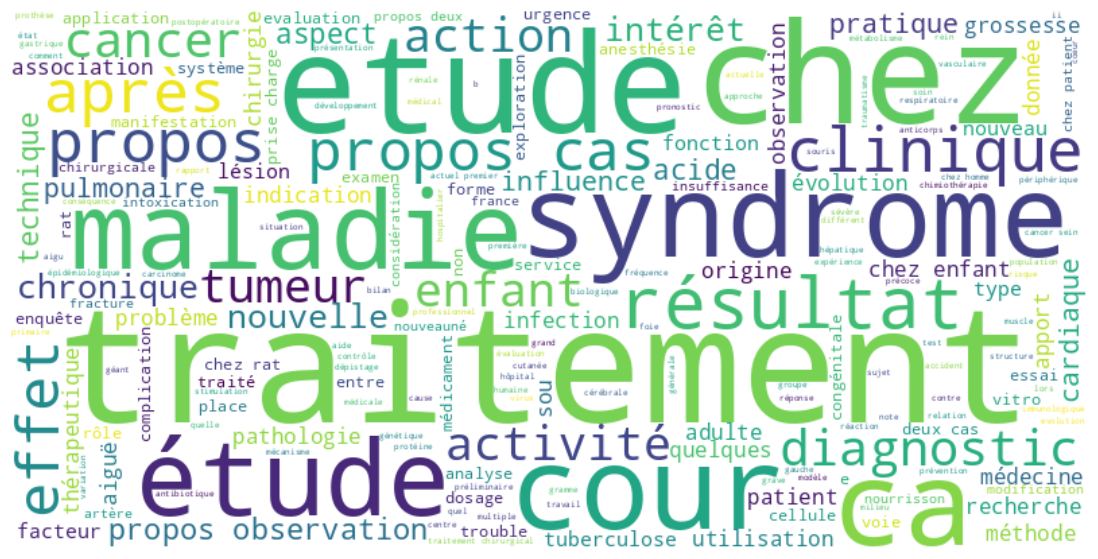

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_all = ' '.join(df['lemmatized_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_all)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


Nuage de mots pour chaque  d'entité


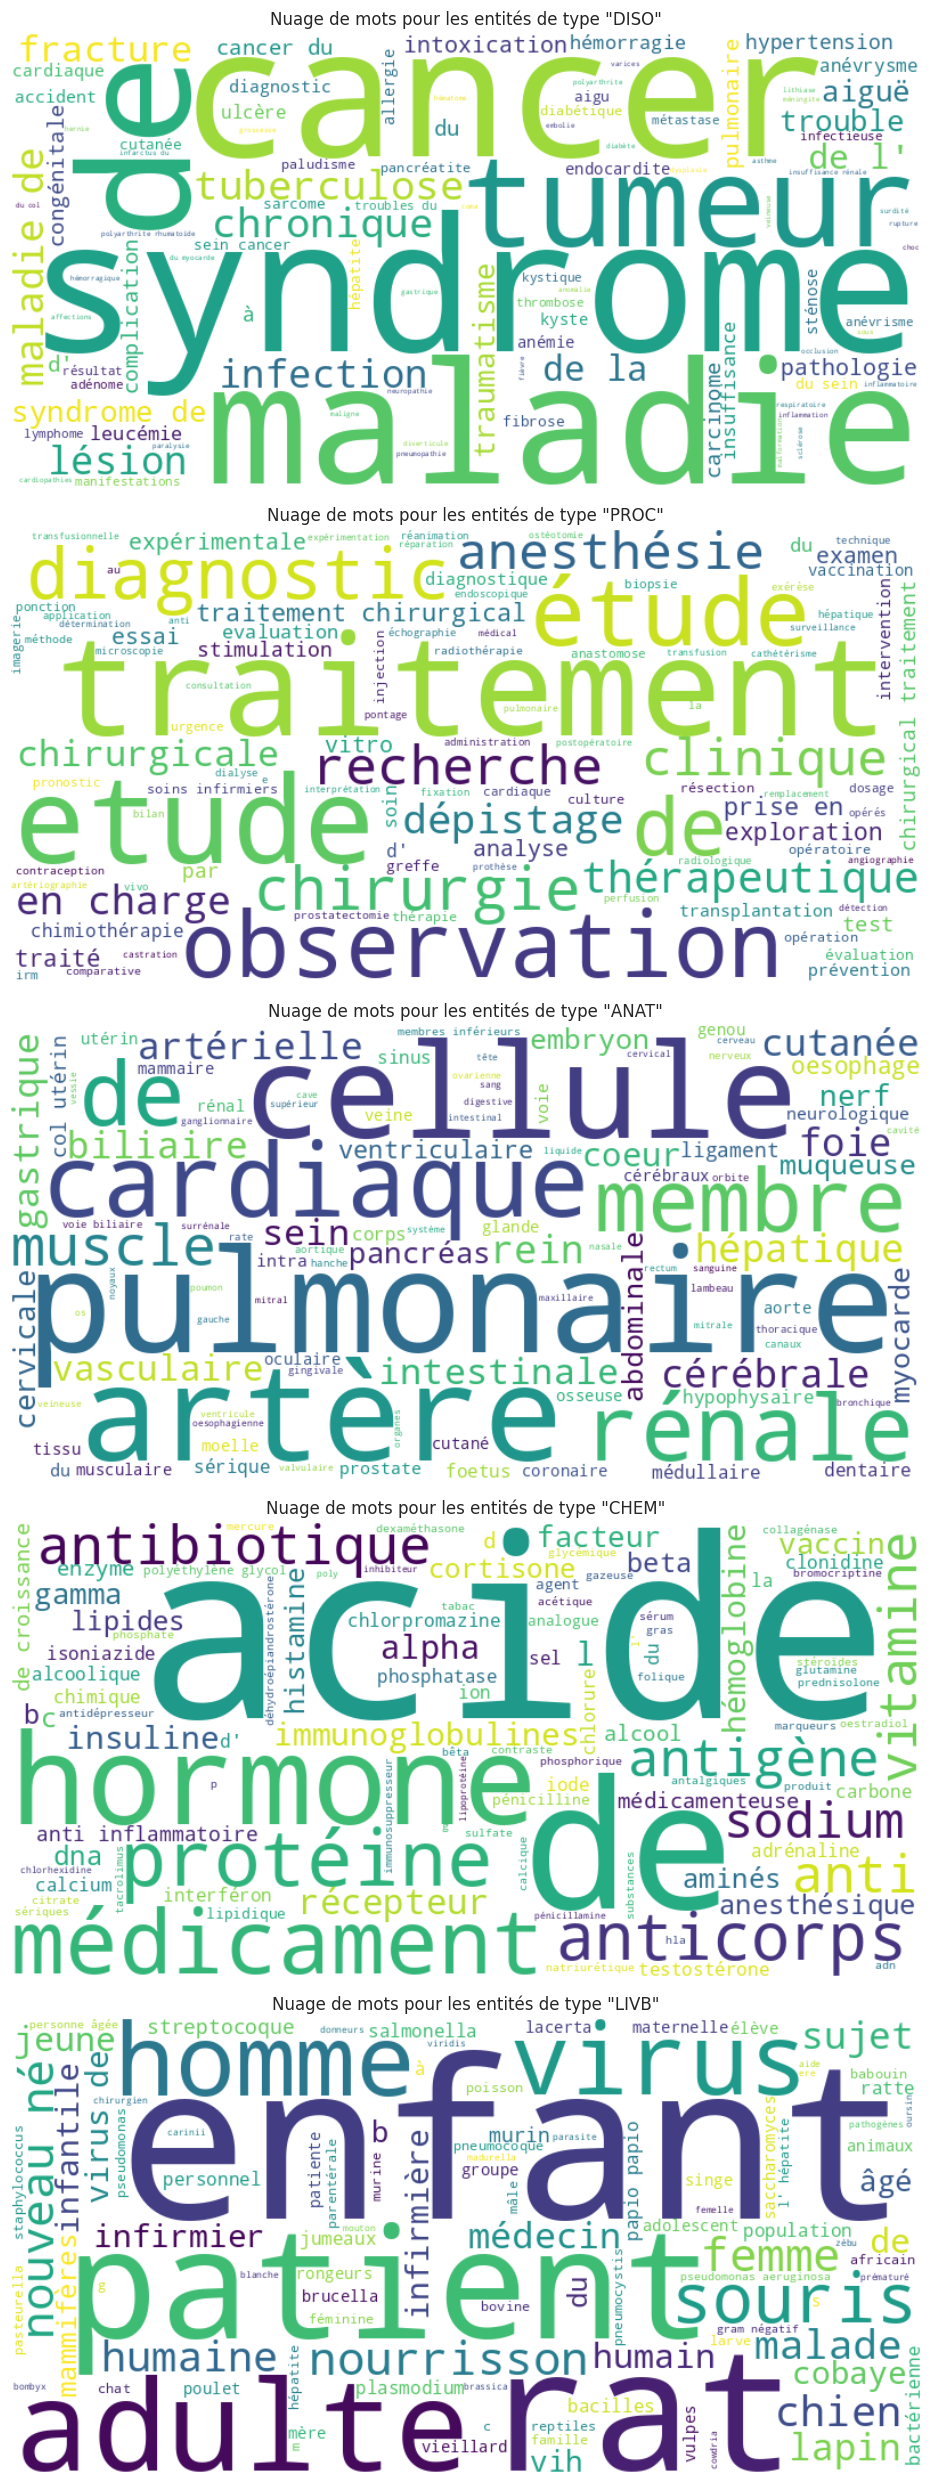

In [ ]:
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Regrouper les textes des entités par type
entity_texts_by_type = defaultdict(list)
entity_counts = Counter()
for annotations in df['annotations']:
    for ann in annotations:
        entity_texts_by_type[ann['type']].append(ann['text'].lower())
        entity_counts[ann['type']] += 1

# Sélectionner les 5 types d'entités les plus fréquents
top_entity_types = [entity_type for entity_type, _ in entity_counts.most_common(5)]

# Créer des sous-graphiques pour chaque type d'entité
fig, axes = plt.subplots(len(top_entity_types), 1, figsize=(15, 5 * len(top_entity_types)))

# Si un seul type d'entité, axes n'est pas une liste
if len(top_entity_types) == 1:
    axes = [axes]

for i, entity_type in enumerate(top_entity_types):
    # Concaténer tous les textes des entités pour ce type
    text = ' '.join(entity_texts_by_type[entity_type])

    # Créer et afficher le nuage de mots
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          max_words=100, contour_width=3).generate(text)

    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Nuage de mots pour les entités de type \"{entity_type}\"')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Répartition des types d'entités médicales dans le corpus QUAERO

In [ ]:
from collections import Counter
import pandas as pd

# Flatten all annotations across all documents
all_labels = []
for annotations in df['annotations']:
    for ann in annotations:
        all_labels.append(ann['type'])

# Count entity types
label_counts = Counter(all_labels)
label_df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['count']).sort_values(by='count', ascending=False)
print(label_df)


      count
DISO   2843
PROC   1750
ANAT   1499
CHEM   1055
LIVB    941
PHYS    469
PHEN    158
GEOG    131
DEVI    128
OBJC    100


Fréquence des types d\'entités médicales dans le corpus QUAERO

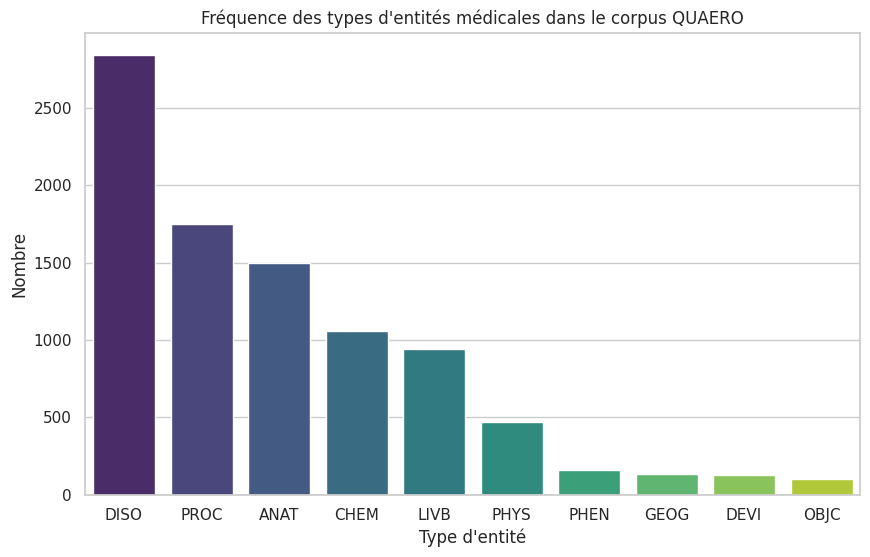

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=label_df.index, y=label_df['count'], hue=label_df.index, palette='viridis', legend=False)
plt.title('Fréquence des types d\'entités médicales dans le corpus QUAERO')
plt.xlabel('Type d\'entité')
plt.ylabel('Nombre')
plt.show()


## 6. Algorithms and Models

###SVM

In [ ]:
from collections import Counter

def most_common_entity_type(annotations):
    if not annotations:
        return 'None'
    types = [ann['type'] for ann in annotations]
    return Counter(types).most_common(1)[0][0]

df['label'] = df['annotations'].apply(most_common_entity_type)


In [ ]:
from sklearn.model_selection import train_test_split

X = df['lemmatized_text']
y = df['label']  # Now contains one label per document

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_features=1000)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)


In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np

# Tokenize the text
X_train_tokens = [word_tokenize(text) for text in X_train]
X_test_tokens = [word_tokenize(text) for text in X_test]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, sg=1)

# Function to compute the average vector for a document
def document_vector(doc):
    doc = [word for word in doc if word in w2v_model.wv]
    return np.mean(w2v_model.wv[doc], axis=0) if doc else np.zeros(w2v_model.vector_size)

# Transform documents to vectors
X_train_w2v = np.array([document_vector(doc) for doc in X_train_tokens])
X_test_w2v = np.array([document_vector(doc) for doc in X_test_tokens])


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

# Initialize SVM classifier
svm_clf = SVC(kernel='linear')

# Dictionary to store results
results = {}

# BoW
svm_clf.fit(X_train_bow, y_train)
y_pred_bow = svm_clf.predict(X_test_bow)
results['BoW'] = {
    'accuracy': accuracy_score(y_test, y_pred_bow),
    'f1_score': f1_score(y_test, y_pred_bow, average='weighted')
}

# TF-IDF
svm_clf.fit(X_train_tfidf, y_train)
y_pred_tfidf = svm_clf.predict(X_test_tfidf)
results['TF-IDF'] = {
    'accuracy': accuracy_score(y_test, y_pred_tfidf),
    'f1_score': f1_score(y_test, y_pred_tfidf, average='weighted')
}

# Word2Vec
svm_clf.fit(X_train_w2v, y_train)
y_pred_w2v = svm_clf.predict(X_test_w2v)
results['Word2Vec'] = {
    'accuracy': accuracy_score(y_test, y_pred_w2v),
    'f1_score': f1_score(y_test, y_pred_w2v, average='weighted')
}


Performance by Vectorization Method:
BoW -> Accuracy: 0.4600, F1 Score: 0.4271
TF-IDF -> Accuracy: 0.5100, F1 Score: 0.4483
Word2Vec -> Accuracy: 0.3860, F1 Score: 0.2150
-----------------------------------------------------------


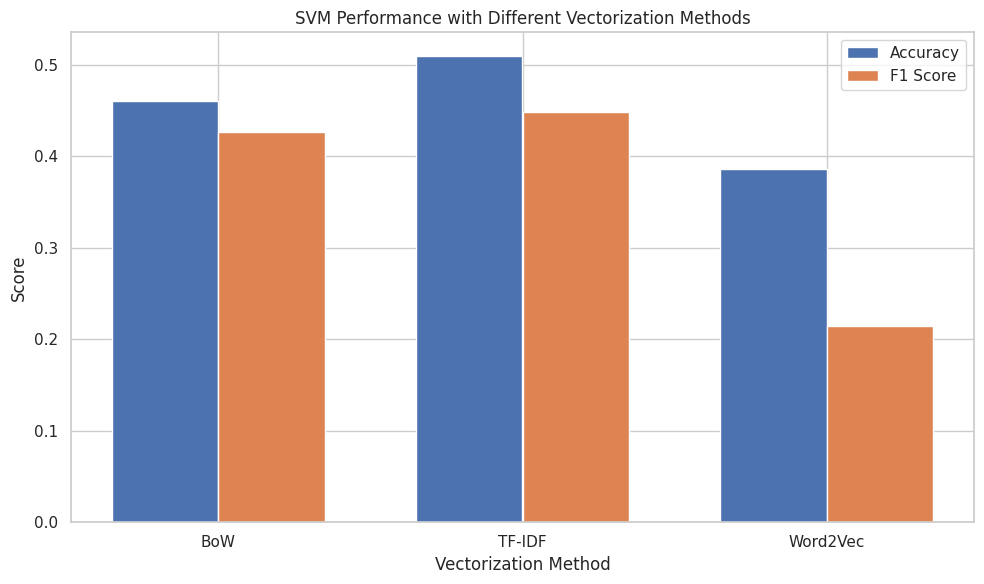

In [ ]:
import matplotlib.pyplot as plt

print("Performance by Vectorization Method:")
for method, metrics in results.items():
    print(f"{method} -> Accuracy: {metrics['accuracy']:.4f}, F1 Score: {metrics['f1_score']:.4f}")
print("-----------------------------------------------------------")

# Extract metrics
methods = list(results.keys())
accuracies = [results[method]['accuracy'] for method in methods]
f1_scores = [results[method]['f1_score'] for method in methods]

# Plotting
x = range(len(methods))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x, accuracies, width, label='Accuracy')
ax.bar([p + width for p in x], f1_scores, width, label='F1 Score')

# Labels and titles
ax.set_xlabel('Vectorization Method')
ax.set_ylabel('Score')
ax.set_title('SVM Performance with Different Vectorization Methods')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(methods)
ax.legend()

plt.tight_layout()
plt.show()


### Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score

# Store results
nb_results = {}

# --- TF-IDF ---
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)

acc_tfidf = accuracy_score(y_test, y_pred_tfidf)
f1_tfidf = f1_score(y_test, y_pred_tfidf, average='weighted')

nb_results['TF-IDF'] = {'accuracy': acc_tfidf, 'f1_score': f1_tfidf}

# --- Bag of Words ---
nb_bow = MultinomialNB()
nb_bow.fit(X_train_bow, y_train)
y_pred_bow = nb_bow.predict(X_test_bow)

acc_bow = accuracy_score(y_test, y_pred_bow)
f1_bow = f1_score(y_test, y_pred_bow, average='weighted')

nb_results['Bag of Words'] = {'accuracy': acc_bow, 'f1_score': f1_bow}


Naive Bayes Performance:
TF-IDF -> Accuracy: 0.4740, F1 Score: 0.3755
Bag of Words -> Accuracy: 0.4800, F1 Score: 0.4312
-----------------------------------------------------------


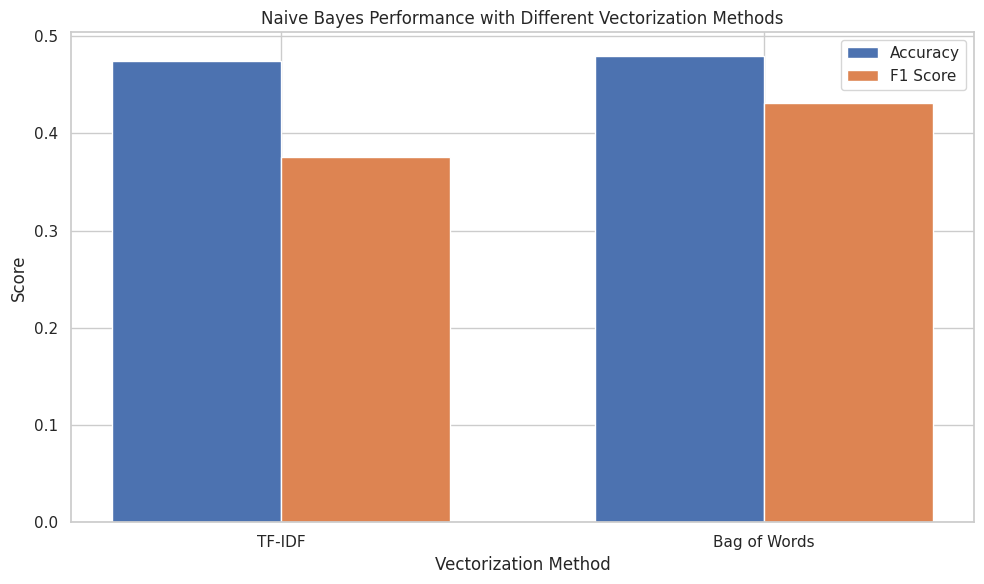

In [ ]:
import matplotlib.pyplot as plt

# Print Naive Bayes results
print("Naive Bayes Performance:")
for method, metrics in nb_results.items():
    print(f"{method} -> Accuracy: {metrics['accuracy']:.4f}, F1 Score: {metrics['f1_score']:.4f}")
print("-----------------------------------------------------------")



# Extract metrics
methods = list(nb_results.keys())
accuracies = [nb_results[method]['accuracy'] for method in methods]
f1_scores = [nb_results[method]['f1_score'] for method in methods]

# Plotting
x = range(len(methods))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x, accuracies, width, label='Accuracy')
ax.bar([p + width for p in x], f1_scores, width, label='F1 Score')

# Labels and titles
ax.set_xlabel('Vectorization Method')
ax.set_ylabel('Score')
ax.set_title('Naive Bayes Performance with Different Vectorization Methods')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(methods)
ax.legend()

plt.tight_layout()
plt.show()


###logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Store results
lr_results = {}

# --- TF-IDF ---
lr_tfidf = LogisticRegression(max_iter=1000)
lr_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)

acc_tfidf = accuracy_score(y_test, y_pred_tfidf)
f1_tfidf = f1_score(y_test, y_pred_tfidf, average='weighted')

lr_results['TF-IDF'] = {'accuracy': acc_tfidf, 'f1_score': f1_tfidf}

# --- Bag of Words ---
lr_bow = LogisticRegression(max_iter=1000)
lr_bow.fit(X_train_bow, y_train)
y_pred_bow = lr_bow.predict(X_test_bow)

acc_bow = accuracy_score(y_test, y_pred_bow)
f1_bow = f1_score(y_test, y_pred_bow, average='weighted')

lr_results['Bag of Words'] = {'accuracy': acc_bow, 'f1_score': f1_bow}

# --- Word2Vec (average of word vectors) ---
import numpy as np

def vectorize_with_w2v(docs, model, vector_size=100):
    """Average word vectors for each document"""
    vectors = []
    for tokens in docs:
        vecs = [model.wv[word] for word in tokens if word in model.wv]
        if vecs:
            avg_vec = np.mean(vecs, axis=0)
        else:
            avg_vec = np.zeros(vector_size)
        vectors.append(avg_vec)
    return np.array(vectors)

# Assume tokenized_corpus and w2v_model are already defined
X_w2v = vectorize_with_w2v(tokenized_corpus, w2v_model)

# Train/test split for Word2Vec
from sklearn.model_selection import train_test_split
X_train_w2v, X_test_w2v, _, _ = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

# Train logistic regression
lr_w2v = LogisticRegression(max_iter=1000)
lr_w2v.fit(X_train_w2v, y_train)
y_pred_w2v = lr_w2v.predict(X_test_w2v)

acc_w2v = accuracy_score(y_test, y_pred_w2v)
f1_w2v = f1_score(y_test, y_pred_w2v, average='weighted')

lr_results['Word2Vec'] = {'accuracy': acc_w2v, 'f1_score': f1_w2v}


Logistic Regression Performance by Vectorization Method:
TF-IDF → Accuracy: 0.4960, F1 Score: 0.4147
Bag of Words → Accuracy: 0.4880, F1 Score: 0.4308
Word2Vec → Accuracy: 0.3860, F1 Score: 0.2150
-----------------------------------------------------------


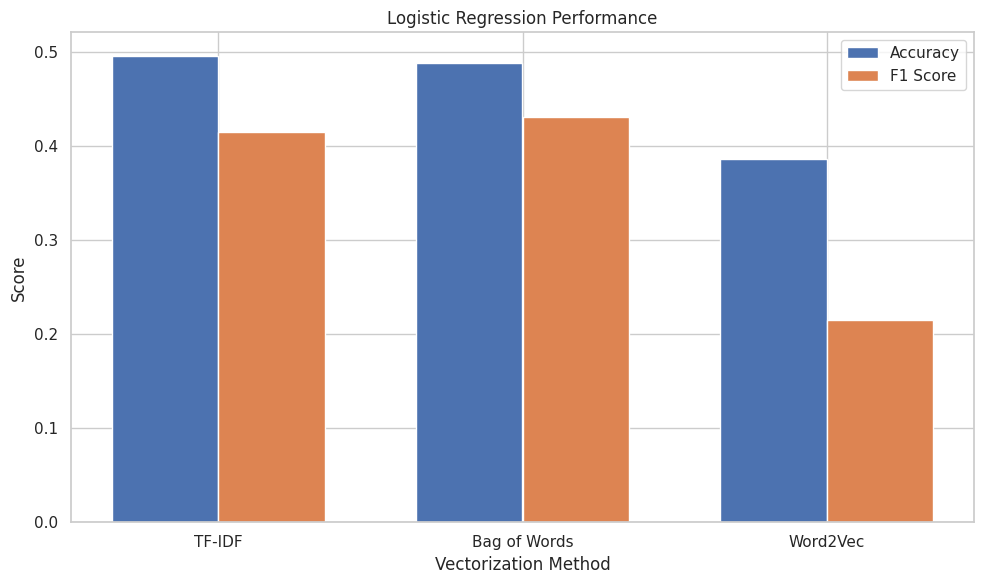

In [ ]:
import matplotlib.pyplot as plt

methods = list(lr_results.keys())
accuracies = [lr_results[m]['accuracy'] for m in methods]
f1_scores = [lr_results[m]['f1_score'] for m in methods]

x = range(len(methods))
width = 0.35

print("Logistic Regression Performance by Vectorization Method:")
for method, metrics in lr_results.items():
    print(f"{method} → Accuracy: {metrics['accuracy']:.4f}, F1 Score: {metrics['f1_score']:.4f}")
print("-----------------------------------------------------------")

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x, accuracies, width, label='Accuracy')
ax.bar([p + width for p in x], f1_scores, width, label='F1 Score')

ax.set_xlabel('Vectorization Method')
ax.set_ylabel('Score')
ax.set_title('Logistic Regression Performance')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(methods)
ax.legend()

plt.tight_layout()
plt.show()


## 7. Named Entity Recognition (NER)

###spaCy NER (tuned model)

Conversion du corpus QUAERO en format spaCy

In [ ]:
from pathlib import Path

def convert_quaero_to_spacy_format(corpus_dir):
    training_data = []
    for file_path in Path(corpus_dir).rglob("*.txt"):
        ann_path = file_path.with_suffix('.ann')
        if not ann_path.exists():
            continue
        text = file_path.read_text(encoding='utf-8')
        entities = []
        for line in ann_path.read_text(encoding='utf-8').splitlines():
            if not line.startswith("T"):
                continue
            parts = line.split('\t')
            if len(parts) < 3:
                continue
            tag_info = parts[1].split()
            label = tag_info[0]
            spans = tag_info[1:]
            if any(";" in s for s in spans):  # sauter discontinuous
                continue
            try:
                start, end = map(int, spans[:2])
                entities.append((start, end, label))
            except ValueError:
                continue
        training_data.append((text, {"entities": entities}))
    return training_data

# Usage
corpus_path = "/content/drive/MyDrive/data/corpus"
all_data = convert_quaero_to_spacy_format(corpus_path)


Séparation train / test



In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(all_data, test_size=0.2, random_state=42)

print(f"Train samples: {len(train_data)}")
print(f"Test samples : {len(test_data)}")


Train samples: 1998
Test samples : 500


Création du pipeline spaCy et ajout du composant NER

In [ ]:
import spacy

nlp = spacy.blank("fr")
ner = nlp.add_pipe("ner")


Collecte des labels depuis les données d’entraînement

In [ ]:
for _, ann in train_data:
    for _, _, label in ann["entities"]:
        ner.add_label(label)


Suppression des entités chevauchantes (overlapping entities)

In [ ]:
from spacy.training.example import Example

def remove_overlapping_entities(entities):
    entities = sorted(entities, key=lambda x: (x[0], -(x[1]-x[0])))
    filtered, last_end = [], -1
    for start, end, label in entities:
        if start >= last_end:
            filtered.append((start, end, label))
            last_end = end
        else:
            prev_start, prev_end, prev_label = filtered[-1]
            if (end-start) > (prev_end-prev_start):
                filtered[-1] = (start, end, label)
                last_end = end
    return filtered

train_examples = []
for text, ann in train_data:
    cleaned = remove_overlapping_entities(ann["entities"])
    doc = nlp.make_doc(text)
    train_examples.append(Example.from_dict(doc, {"entities": cleaned}))


Ré-alignement et nettoyage

In [ ]:
from spacy.training.iob_utils import offsets_to_biluo_tags, biluo_tags_to_offsets

def align_test_data(nlp, raw_data):
    aligned = []
    for text, ann in raw_data:
        doc = nlp.make_doc(text)
        try:
            biluo = offsets_to_biluo_tags(doc, ann["entities"])
            ents  = biluo_tags_to_offsets(doc, biluo)
            ents  = remove_overlapping_entities(ents)
            aligned.append((text, {"entities": ents}))
        except Exception:
            continue
    return aligned

test_data = align_test_data(nlp, test_data)


 Entraînement du modèle NER

In [ ]:
from spacy.util import minibatch, compounding
import random

other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.begin_training()
    for epoch in range(25):
        random.shuffle(train_examples)
        losses = {}
        batches = minibatch(train_examples, size=compounding(4.0, 32.0, 1.5))
        for batch in batches:
            nlp.update(batch, drop=0.5, sgd=optimizer, losses=losses)
        print(f"Epoch {epoch+1} — Loss NER: {losses['ner']:.3f}")


Epoch 1 — Loss NER: 11220.694
Epoch 2 — Loss NER: 7899.261
Epoch 3 — Loss NER: 7429.579
Epoch 4 — Loss NER: 7128.128
Epoch 5 — Loss NER: 6820.497
Epoch 6 — Loss NER: 6614.825
Epoch 7 — Loss NER: 6540.527
Epoch 8 — Loss NER: 6473.164
Epoch 9 — Loss NER: 6353.991
Epoch 10 — Loss NER: 6114.579
Epoch 11 — Loss NER: 5939.472
Epoch 12 — Loss NER: 5767.937
Epoch 13 — Loss NER: 5732.603
Epoch 14 — Loss NER: 5717.528
Epoch 15 — Loss NER: 5438.380
Epoch 16 — Loss NER: 5362.389
Epoch 17 — Loss NER: 5333.102
Epoch 18 — Loss NER: 5117.288
Epoch 19 — Loss NER: 5144.913
Epoch 20 — Loss NER: 4964.050
Epoch 21 — Loss NER: 4886.291
Epoch 22 — Loss NER: 4827.181
Epoch 23 — Loss NER: 4853.763
Epoch 24 — Loss NER: 4713.292
Epoch 25 — Loss NER: 4677.154


Sauvegarde du modèle



In [ ]:
output_dir = "/content/drive/MyDrive/data/ner_model"
nlp.to_disk(output_dir)
print("Model saved to", output_dir)


Model saved to /content/drive/MyDrive/data/ner_model


Évaluation



In [ ]:
import spacy
from spacy.training.example import Example

nlp2 = spacy.load(output_dir)
print("Labels NER:", nlp2.pipe_labels['ner'])

# Préparer les Examples
examples = []
for text, ann in test_data:
    doc = nlp2.make_doc(text)
    examples.append(Example.from_dict(doc, ann))

# scorer via spaCy
scorer = nlp2.evaluate(examples)
print("\n=== Résultats d’évaluation ===")
print(f"Précision : {scorer['ents_p']*100:.2f}%")
print(f"Rappel    : {scorer['ents_r']*100:.2f}%")
print(f"F1-score  : {scorer['ents_f']*100:.2f}%")
print("Métriques par type :", scorer["ents_per_type"])


Labels NER: ['ANAT', 'CHEM', 'DEVI', 'DISO', 'GEOG', 'LIVB', 'OBJC', 'PHEN', 'PHYS', 'PROC']

=== Résultats d’évaluation ===
Précision : 44.27%
Rappel    : 36.84%
F1-score  : 40.22%
Métriques par type : {'DISO': {'p': 0.3668639053254438, 'r': 0.3712574850299401, 'f': 0.36904761904761907}, 'PROC': {'p': 0.4609375, 'r': 0.45384615384615384, 'f': 0.45736434108527135}, 'ANAT': {'p': 0.35555555555555557, 'r': 0.23529411764705882, 'f': 0.2831858407079646}, 'CHEM': {'p': 0.5423728813559322, 'r': 0.48484848484848486, 'f': 0.5120000000000001}, 'PHEN': {'p': 0.0, 'r': 0.0, 'f': 0.0}, 'PHYS': {'p': 0.3684210526315789, 'r': 0.16666666666666666, 'f': 0.22950819672131145}, 'LIVB': {'p': 0.5256410256410257, 'r': 0.45054945054945056, 'f': 0.48520710059171596}, 'GEOG': {'p': 0.875, 'r': 0.5, 'f': 0.6363636363636364}, 'OBJC': {'p': 0.0, 'r': 0.0, 'f': 0.0}, 'DEVI': {'p': 0.0, 'r': 0.0, 'f': 0.0}}


In [ ]:
test_paragraph = (
    "Le patient a été admis pour une pneumonie lobaire droite le 12 mars 2025. "
    "Il a immédiatement reçu de l'amoxicilline 1 g trois fois par jour pendant 7 jours. "
    "Une radiographie thoracique de contrôle a montré une opacité du lobe inférieur droit. "
    "Le coeur et les vaisseaux étaient normaux."
)


test_annotations = {
    "entities": [
        (32, 56, "DISO"),   # "pneumonie lobaire droite"
        (60, 73, "PHEN"),   # "12 mars 2025"
        (103, 115, "CHEM"), # "amoxicilline"
        (161, 185, "PROC"), # "radiographie thoracique"
        (246, 251, "ANAT")  # "coeur"
    ]
}

import spacy

nlp2 = spacy.load(output_dir)  # votre dossier de modèle
doc = nlp2(test_paragraph)

print("=== Prédictions du modèle ===")
for ent in doc.ents:
    print(f"- Texte : '{ent.text}' | Label : {ent.label_} | Span : ({ent.start_char}, {ent.end_char})")

print("\n=== Annotations exact ===")
for start, end, label in test_annotations["entities"]:
    print(f"- Texte : '{test_paragraph[start:end]}' | Label : {label} | Span : ({start}, {end})")


=== Prédictions du modèle ===
- Texte : 'patient' | Label : LIVB | Span : (3, 10)
- Texte : 'pneumonie lobaire' | Label : DISO | Span : (32, 49)
- Texte : 'amoxicilline' | Label : CHEM | Span : (103, 115)
- Texte : 'radiographie thoracique' | Label : DISO | Span : (161, 184)
- Texte : 'inférieur droit' | Label : ANAT | Span : (226, 241)
- Texte : 'coeur' | Label : ANAT | Span : (246, 251)

=== Annotations exact ===
- Texte : 'pneumonie lobaire droite' | Label : DISO | Span : (32, 56)
- Texte : '12 mars 2025.' | Label : PHEN | Span : (60, 73)
- Texte : 'amoxicilline' | Label : CHEM | Span : (103, 115)
- Texte : 'radiographie thoracique ' | Label : PROC | Span : (161, 185)
- Texte : 'coeur' | Label : ANAT | Span : (246, 251)


###Conditional Random Fields (CRF)

In [ ]:
!pip install sklearn-crfsuite python-crfsuite


In [ ]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=0935c53db8f0aa6d22d213e5d44cc4cffd80dcbebfd525937113292d05bbccf1
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [ ]:
import os
import glob
import spacy
from spacy.tokens import Doc
from collections import defaultdict

nlp = spacy.blank("fr")  # Tokeniseur seulement

def load_quaero_annotations(ann_path):
    """
    Charge les annotations d'un fichier .ann
    Retourne une liste de tuples : (start, end, label)
    """
    annotations = []
    with open(ann_path, 'r', encoding='utf-8') as f:
        for line in f:
            if not line.startswith("T"):
                continue
            parts = line.strip().split('\t')
            if len(parts) < 3:
                continue
            tag_info = parts[1].split()
            label = tag_info[0]
            if ";" in parts[1]:  # saut des entités discontinues
                continue
            start, end = int(tag_info[1]), int(tag_info[2])
            annotations.append((start, end, label))
    return annotations

def bio_tag_tokens(doc, annotations):
    """
    Aligne les tokens d'un Doc spaCy avec les annotations (start, end, label)
    et retourne une liste de tags BIO.
    """
    tags = ['O'] * len(doc)
    for start, end, label in annotations:
        for i, token in enumerate(doc):
            if token.idx >= end or token.idx + len(token) <= start:
                continue
            if token.idx >= start and token.idx + len(token) <= end:
                if tags[i] == 'O':
                    tags[i] = 'B-' + label
                elif tags[i].startswith('B-'):
                    tags[i] = 'I-' + label
    return tags

def preprocess_quaero_folder(corpus_dir):
    dataset = []
    for txt_path in glob.glob(os.path.join(corpus_dir, "*.txt")):
        base = os.path.splitext(txt_path)[0]
        ann_path = base + ".ann"
        if not os.path.exists(ann_path):
            continue

        with open(txt_path, 'r', encoding='utf-8') as f:
            text = f.read()

        annotations = load_quaero_annotations(ann_path)
        doc = nlp(text)

        tags = bio_tag_tokens(doc, annotations)
        sentence = [(token.text, tags[i]) for i, token in enumerate(doc)]
        dataset.append(sentence)

    return dataset


In [ ]:
corpus_path = "/content/drive/MyDrive/data/corpus"
bio_dataset = preprocess_quaero_folder(corpus_path)

# Exemple d'une phrase transformée :
for token, tag in bio_dataset[0][:10]:
    print(f"{token:15} {tag}")


L               O
'               O
action          O
de              O
la              O
testostérone    B-CHEM
sur             O
les             O
premières       O
phases          O


In [ ]:
def extract_features(sentence, i):

    word = sentence[i][0]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }

    if i > 0:
        prev_word = sentence[i - 1][0]
        features.update({
            '-1:word.lower()': prev_word.lower(),
            '-1:word.istitle()': prev_word.istitle(),
            '-1:word.isupper()': prev_word.isupper(),
        })
    else:
        features['BOS'] = True  # Beginning of sentence

    if i < len(sentence) - 1:
        next_word = sentence[i + 1][0]
        features.update({
            '+1:word.lower()': next_word.lower(),
            '+1:word.istitle()': next_word.istitle(),
            '+1:word.isupper()': next_word.isupper(),
        })
    else:
        features['EOS'] = True  # End of sentence

    return features


In [ ]:
def sent2features(sent):
    return [extract_features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for _, label in sent]


In [ ]:
# Supposons que bio_dataset soit le résultat du prétraitement QUAERO
X = [sent2features(s) for s in bio_dataset]
y = [sent2labels(s) for s in bio_dataset]

# Affichage d'un exemple :
from pprint import pprint
pprint(X[0][:3])  # Les 3 premiers tokens de la 1ère phrase
pprint(y[0][:3])


[{'+1:word.istitle()': False,
  '+1:word.isupper()': False,
  '+1:word.lower()': "'",
  'BOS': True,
  'bias': 1.0,
  'word.isdigit()': False,
  'word.istitle()': True,
  'word.isupper()': True,
  'word.lower()': 'l',
  'word[-2:]': 'L',
  'word[-3:]': 'L'},
 {'+1:word.istitle()': False,
  '+1:word.isupper()': False,
  '+1:word.lower()': 'action',
  '-1:word.istitle()': True,
  '-1:word.isupper()': True,
  '-1:word.lower()': 'l',
  'bias': 1.0,
  'word.isdigit()': False,
  'word.istitle()': False,
  'word.isupper()': False,
  'word.lower()': "'",
  'word[-2:]': "'",
  'word[-3:]': "'"},
 {'+1:word.istitle()': False,
  '+1:word.isupper()': False,
  '+1:word.lower()': 'de',
  '-1:word.istitle()': False,
  '-1:word.isupper()': False,
  '-1:word.lower()': "'",
  'bias': 1.0,
  'word.isdigit()': False,
  'word.istitle()': False,
  'word.isupper()': False,
  'word.lower()': 'action',
  'word[-2:]': 'on',
  'word[-3:]': 'ion'}]
['O', 'O', 'O']


In [ ]:
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn.model_selection import train_test_split


X = [sent2features(s) for s in bio_dataset]
y = [sent2labels(s) for s in bio_dataset]

# Diviser les données en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer le modèle CRF
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',  # bon compromis entre performance et rapidité
    c1=0.1,              # coefficient L1
    c2=0.1,              # coefficient L2
    max_iterations=100,
    all_possible_transitions=True
)

# Entraîner
crf.fit(X_train, y_train)

# Sauvegarder le modèle (optionnel)
import joblib
joblib.dump(crf, 'crf_ner_quaero.joblib')


['crf_ner_quaero.joblib']

In [ ]:
# Prédire sur le jeu de test
y_pred = crf.predict(X_test)

# Afficher le rapport
labels = list(crf.classes_)
labels.remove('O')  # On enlève la classe "non-annotée"

print(metrics.flat_classification_report(y_test, y_pred, labels=labels, digits=3))


              precision    recall  f1-score   support

      B-CHEM      0.549     0.476     0.510       166
      B-PHYS      0.432     0.162     0.235        99
      I-PHYS      0.333     0.071     0.118        28
      B-LIVB      0.704     0.451     0.550       195
      B-PROC      0.656     0.489     0.560       374
      B-ANAT      0.364     0.246     0.294       191
      B-DISO      0.535     0.472     0.501       532
      I-DISO      0.459     0.368     0.409       152
      I-ANAT      0.542     0.359     0.432       145
      I-PROC      0.600     0.235     0.338        51
      I-LIVB      0.200     0.158     0.176        19
      B-GEOG      0.615     0.348     0.444        23
      I-DEVI      0.000     0.000     0.000         7
      B-DEVI      0.667     0.077     0.138        26
      I-CHEM      0.611     0.183     0.282        60
      B-PHEN      0.000     0.000     0.000        31
      B-OBJC      1.000     0.107     0.194        28
      I-PHEN      0.000    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### BERT (CamemBERT)

In [ ]:
!pip install -q transformers datasets seqeval


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
MODEL_NAME = "camembert-base"  # OR keep "camembert-base" if preferred


In [ ]:
# 1. Imports
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    DataCollatorForTokenClassification, Trainer, TrainingArguments
)
import numpy as np
from seqeval.metrics import classification_report

# 2. Prepare label mapping
unique_tags = sorted({tag for sent in bio_dataset for _, tag in sent})
label_list = unique_tags
label_to_id = {l: i for i, l in enumerate(label_list)}
id_to_label = {i: l for l, i in label_to_id.items()}

# 3. Build Hugging Face dataset
tokens = [[tok for tok, tag in sent] for sent in bio_dataset]
tags   = [[tag for tok, tag in sent] for sent in bio_dataset]
dataset = Dataset.from_dict({"tokens": tokens, "tags": tags}).train_test_split(test_size=0.2)

# 4. Load tokenizer & model (DrBERT or CamemBERT)
MODEL_NAME = "camembert/camembert-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_list),
    id2label=id_to_label,
    label2id=label_to_id
)

# 5. Tokenization function
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], is_split_into_words=True, truncation=True,
        padding="max_length", max_length=128
    )
    labels = []
    for i, label in enumerate(examples["tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        prev_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != prev_word_idx:
                label_ids.append(label_to_id[label[word_idx]])
            else:
                tag = label[word_idx]
                label_ids.append(label_to_id["I-" + tag[2:]] if tag.startswith("B-") else label_to_id[tag])
            prev_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# 6. Tokenize dataset
tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True, remove_columns=["tokens", "tags"])
data_collator = DataCollatorForTokenClassification(tokenizer)

# 7. Compute metrics
def compute_metrics(p):
    preds, labels = p
    preds = np.argmax(preds, axis=2)
    true_preds, true_labels = [], []
    for pred, label in zip(preds, labels):
        t_pred, t_label = [], []
        for p_, l_ in zip(pred, label):
            if l_ == -100:
                continue
            t_label.append(label_list[l_])
            t_pred.append(label_list[p_])
        true_labels.append(t_label)
        true_preds.append(t_pred)
    report = classification_report(true_labels, true_preds, output_dict=True)
    return {
        "precision": report["macro avg"]["precision"],
        "recall": report["macro avg"]["recall"],
        "f1": report["macro avg"]["f1-score"]
    }

# 8. TrainingArguments
training_args = TrainingArguments(
    output_dir="./ner-output",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    save_steps=500,
    eval_steps=500,
    save_total_limit=2,
    do_train=True,
    do_eval=True,
    report_to=["none"],  # Disable W&B
    push_to_hub=False
)

# 9. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# 10. Train
trainer.train()
trainer.evaluate()


config.json:   0%|          | 0.00/509 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at camembert/camembert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1998 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

<ipython-input-11-9e1fa2e0aa4a>:100: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,2.191900
200,1.785900
300,1.593700
400,1.453800
500,1.369400
600,1.264500
700,1.190600
800,1.147600
900,1.086400
1000,1.045900


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.0928562879562378,
 'eval_precision': 0.27338770220679764,
 'eval_recall': 0.2795583678331426,
 'eval_f1': 0.27603910791082975,
 'eval_runtime': 3.7348,
 'eval_samples_per_second': 133.875,
 'eval_steps_per_second': 16.868,
 'epoch': 5.0}

In [ ]:
MODEL_NAME = "Dr-BERT/DrBERT-7GB"  # OR keep "camembert-base" if preferred


In [ ]:
# 1. Imports
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    DataCollatorForTokenClassification, Trainer, TrainingArguments
)
import numpy as np
from seqeval.metrics import classification_report

# 2. Prepare label mapping
unique_tags = sorted({tag for sent in bio_dataset for _, tag in sent})
label_list = unique_tags
label_to_id = {l: i for i, l in enumerate(label_list)}
id_to_label = {i: l for l, i in label_to_id.items()}

# 3. Build Hugging Face dataset
tokens = [[tok for tok, tag in sent] for sent in bio_dataset]
tags   = [[tag for tok, tag in sent] for sent in bio_dataset]
dataset = Dataset.from_dict({"tokens": tokens, "tags": tags}).train_test_split(test_size=0.2)

# 4. Load tokenizer & model (DrBERT or CamemBERT)
MODEL_NAME = "Dr-BERT/DrBERT-7GB"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_list),
    id2label=id_to_label,
    label2id=label_to_id
)

# 5. Tokenization function
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], is_split_into_words=True, truncation=True,
        padding="max_length", max_length=128
    )
    labels = []
    for i, label in enumerate(examples["tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        prev_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != prev_word_idx:
                label_ids.append(label_to_id[label[word_idx]])
            else:
                tag = label[word_idx]
                label_ids.append(label_to_id["I-" + tag[2:]] if tag.startswith("B-") else label_to_id[tag])
            prev_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# 6. Tokenize dataset
tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True, remove_columns=["tokens", "tags"])
data_collator = DataCollatorForTokenClassification(tokenizer)

# 7. Compute metrics
def compute_metrics(p):
    preds, labels = p
    preds = np.argmax(preds, axis=2)
    true_preds, true_labels = [], []
    for pred, label in zip(preds, labels):
        t_pred, t_label = [], []
        for p_, l_ in zip(pred, label):
            if l_ == -100:
                continue
            t_label.append(label_list[l_])
            t_pred.append(label_list[p_])
        true_labels.append(t_label)
        true_preds.append(t_pred)
    report = classification_report(true_labels, true_preds, output_dict=True)
    return {
        "precision": report["macro avg"]["precision"],
        "recall": report["macro avg"]["recall"],
        "f1": report["macro avg"]["f1-score"]
    }

# 8. TrainingArguments
training_args = TrainingArguments(
    output_dir="./ner-output",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    save_steps=500,
    eval_steps=500,
    save_total_limit=2,
    do_train=True,
    do_eval=True,
    report_to=["none"],  # Disable W&B
    push_to_hub=False
)

# 9. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# 10. Train
trainer.train()
trainer.evaluate()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/791k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/353 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at Dr-BERT/DrBERT-7GB and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1998 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

<ipython-input-8-20e59583cc38>:100: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Step,Training Loss
100,1.087600
200,0.758100
300,0.635500
400,0.541900
500,0.532700
600,0.397400
700,0.364700
800,0.323400
900,0.268300
1000,0.266500


{'eval_loss': 0.7302418947219849,
 'eval_precision': 0.5236139215206828,
 'eval_recall': 0.47179505097542423,
 'eval_f1': 0.47467287199332386,
 'eval_runtime': 3.3836,
 'eval_samples_per_second': 147.773,
 'eval_steps_per_second': 18.619,
 'epoch': 5.0}

Save the fine-tuned model

In [ ]:
# Save model, tokenizer, and config
model_path = "/content/drive/MyDrive/data/Dr-BERT_finetuned"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)


('/content/drive/MyDrive/data/Dr-BERT_finetuned/tokenizer_config.json',
 '/content/drive/MyDrive/data/Dr-BERT_finetuned/special_tokens_map.json',
 '/content/drive/MyDrive/data/Dr-BERT_finetuned/sentencepiece.bpe.model',
 '/content/drive/MyDrive/data/Dr-BERT_finetuned/added_tokens.json',
 '/content/drive/MyDrive/data/Dr-BERT_finetuned/tokenizer.json')

In [ ]:
from huggingface_hub import login

# Login using your Hugging Face token
login(token="")

# Save and push to the hub
model.push_to_hub("abdel132/ner-drbert-quaero")
tokenizer.push_to_hub("abdel132/ner-drbert-quaero")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/791k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/abdel132/ner-drbert-quaero/commit/ac2c43f0813cf535428bc8dcf82d02cdfe4ff222', commit_message='Upload tokenizer', commit_description='', oid='ac2c43f0813cf535428bc8dcf82d02cdfe4ff222', pr_url=None, repo_url=RepoUrl('https://huggingface.co/abdel132/ner-drbert-quaero', endpoint='https://huggingface.co', repo_type='model', repo_id='abdel132/ner-drbert-quaero'), pr_revision=None, pr_num=None)

In [ ]:
model

CamembertForTokenClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tr

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

# === 1. Load your fine-tuned model ===
model_path = "./ner-output/checkpoint-1250"  # or a HuggingFace repo like "yourusername/DrBERT-quaero"
model = AutoModelForTokenClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# === 2. Load NER pipeline ===
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

# === 3. Example text ===
text = "Le patient présente une douleur thoracique et a reçu 500 mg de paracétamol."

# === 4. Run the model ===
results = ner_pipeline(text)

# === 5. Print predictions ===
for entity in results:
    print(f"{entity['word']} → {entity['entity_group']} (score={entity['score']:.2f})")


Device set to use cuda:0


patient → LIVB (score=0.96)
douleur → DISO (score=0.74)
thoracique → ANAT (score=0.72)
paracétamol → CHEM (score=0.99)
